# Met Éireann Reanalysis - Evapotranspiration

Derive evapotranspiration using the FAO Penman-Monteith equation

In [1]:
# import libraries
import glob
import os
from datetime import datetime, timezone
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.plot_configs as cplt

In [4]:
# directory of processed MÉRA netCDF files
DATA_DIR = os.path.join("/run/media/nms/MyPassport", "MERA", "netcdf_day")

In [5]:
# list of variables needed to derive ET
var_dirs = [
    "1_105_0_0",    # surface pressure
    "15_105_2_2",   # max temperature
    "16_105_2_2",   # min temperature
    "33_105_10_0",  # u-component of 10 m wind
    "34_105_10_0",  # v-component of 10 m wind
    "52_105_2_0",   # 2 m relative humidity
    "111_105_0_4",  # net shortwave irradiance
    "112_105_0_4"   # net longwave irradiance
]

In [6]:
# dictionary to store Xarray datasets
ds = {}

In [7]:
for var in var_dirs:
    ds[var] = xr.open_mfdataset(
        glob.glob(os.path.join(DATA_DIR, f"MERA_{var}_day.nc")),
        chunks="auto", decode_coords="all"
    )

In [8]:
# obtain CRS info
data_crs = ds["1_105_0_0"].rio.crs

In [9]:
# drop the height dimension from the datasets
for v in var_dirs:
    ds[v] = ds[v].isel(height=0)

## Visualise the variables

In [2]:
# Moorepark, Fermoy met station coords
LON, LAT = -8.26389, 52.16389

In [3]:
# transform coordinates from lon/lat to Lambert Conformal Conic
XLON, YLAT = cplt.lambert_conformal.transform_point(
    x=LON, y=LAT, src_crs=ccrs.PlateCarree()
)

In [10]:
def plot_map(data, var, cmap="Spectral_r"):
    """
    Helper function for plotting maps
    """

    plt.figure(figsize=(9, 7))
    ax = plt.axes(projection=cplt.lambert_conformal)
    data.isel(time=120)[var].plot.contourf(
        ax=ax, robust=True, x="x", y="y", levels=10,
        transform=cplt.lambert_conformal,
        cmap=cmap,
        cbar_kwargs={
            "label": (
                data[var].attrs["long_name"] +
                " [" + data[var].attrs["units"] + "]"
            )
        }
    )
    ax.gridlines(
        draw_labels=dict(bottom="x", left="y"),
        color="lightslategrey",
        linewidth=.5,
        x_inline=False,
        y_inline=False
    )
    ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
    ax.set_title(str(data.isel(time=90)["time"].values))
    plt.tight_layout()
    plt.show()

In [11]:
def plot_ts(data, var):
    """
    Helper function for plotting time series
    """

    plt.figure(figsize=(12, 4))
    data_ts = data.sel({"x": XLON, "y": YLAT}, method="nearest")
    data_ts = data_ts.sel(time=slice("1989", "1991"))
    plt.plot(data_ts["time"], data_ts[var])
    plt.title(
        data[var].attrs["long_name"] + " [" + data[var].attrs["units"] + "]"
    )
    plt.tight_layout()
    plt.show()

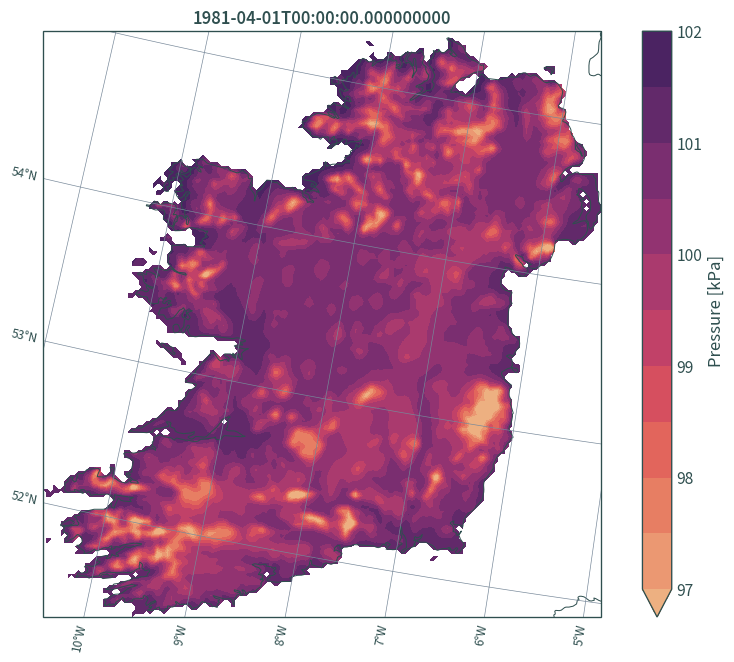

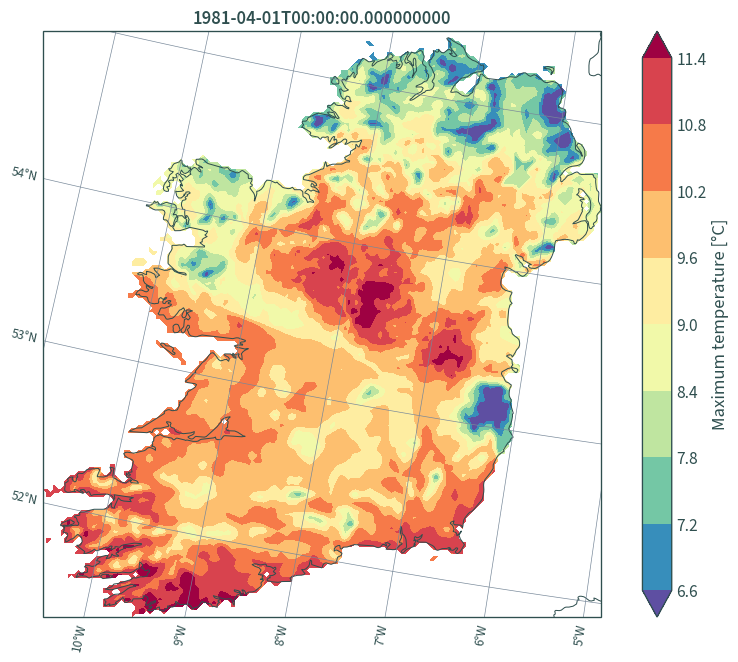

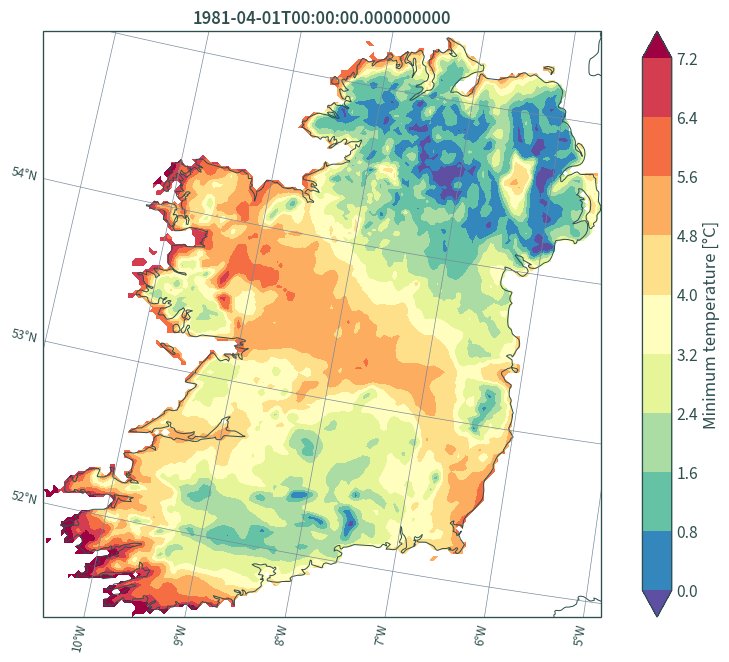

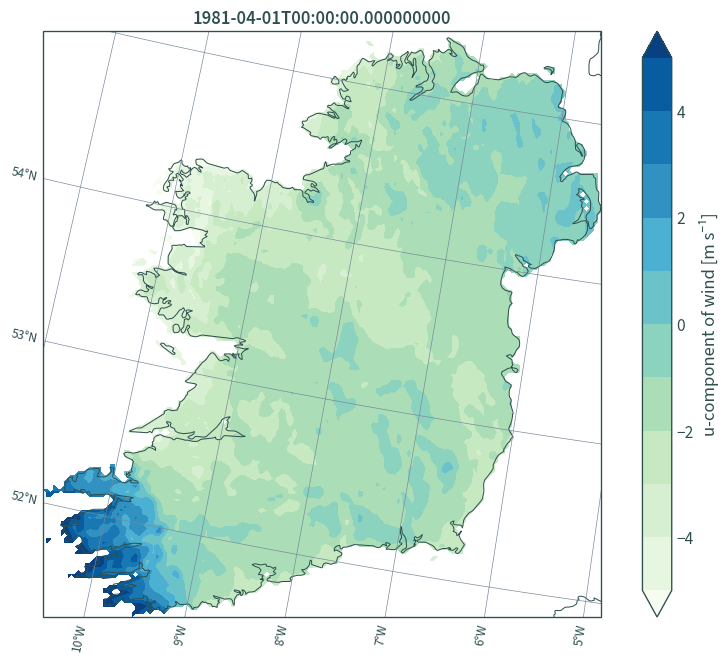

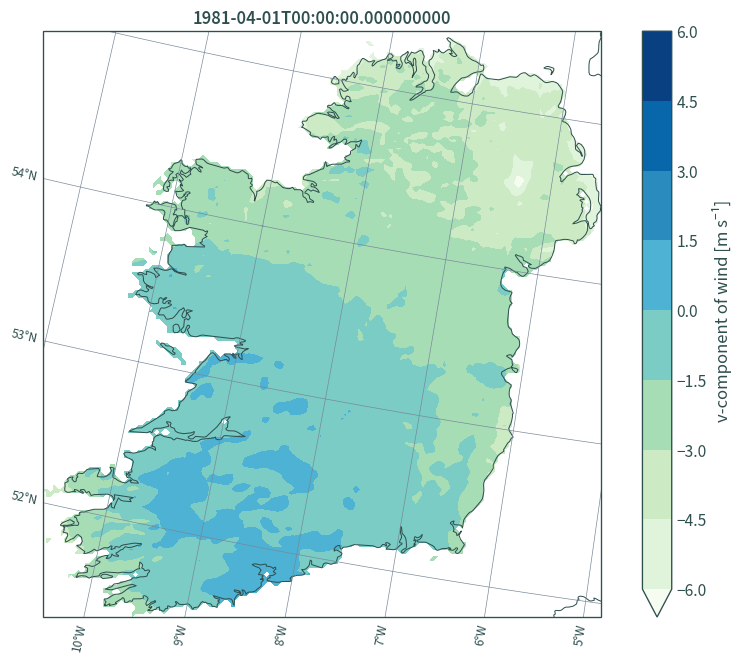

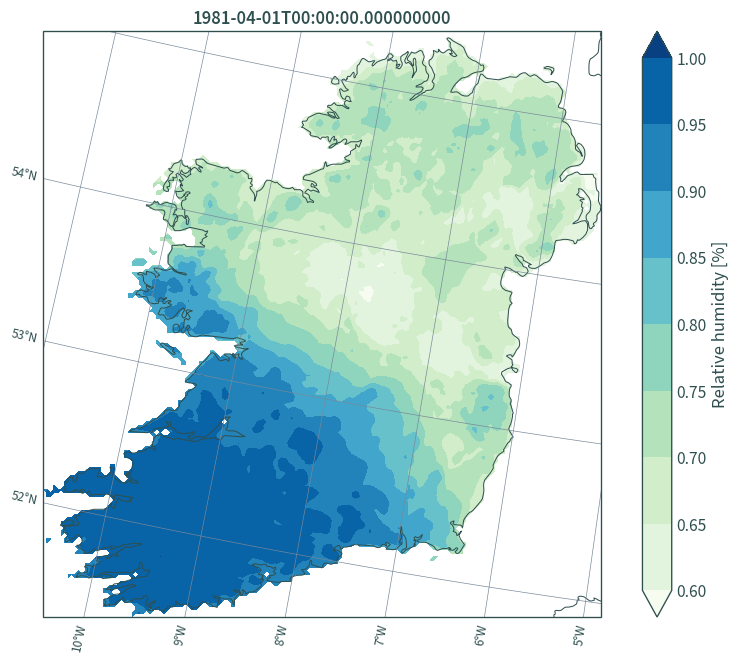

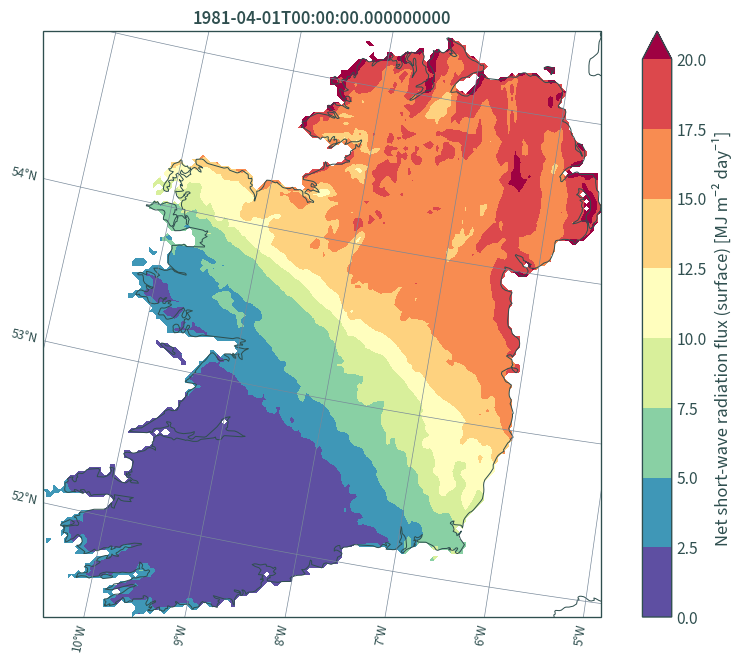

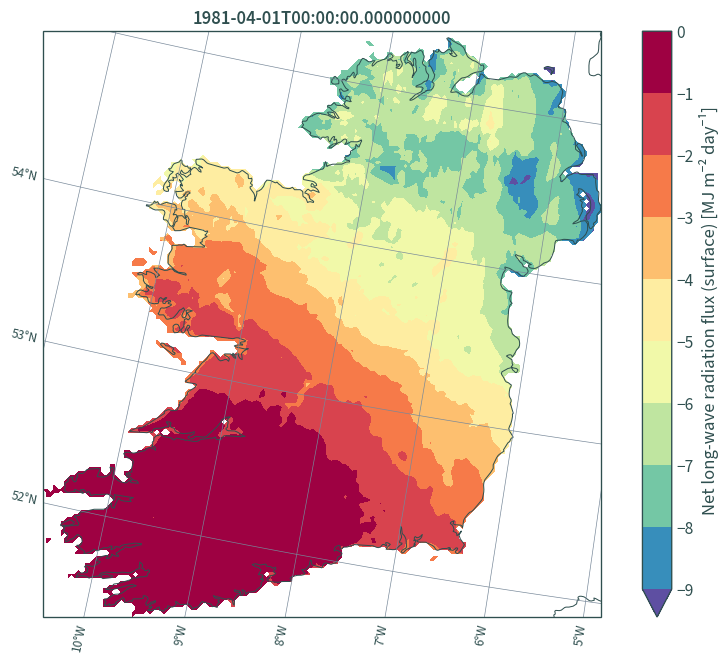

In [12]:
for v in var_dirs:
    var = list(ds[v].data_vars)[0]
    plot_map(ds[v], var, cplt.colormap_configs(var))

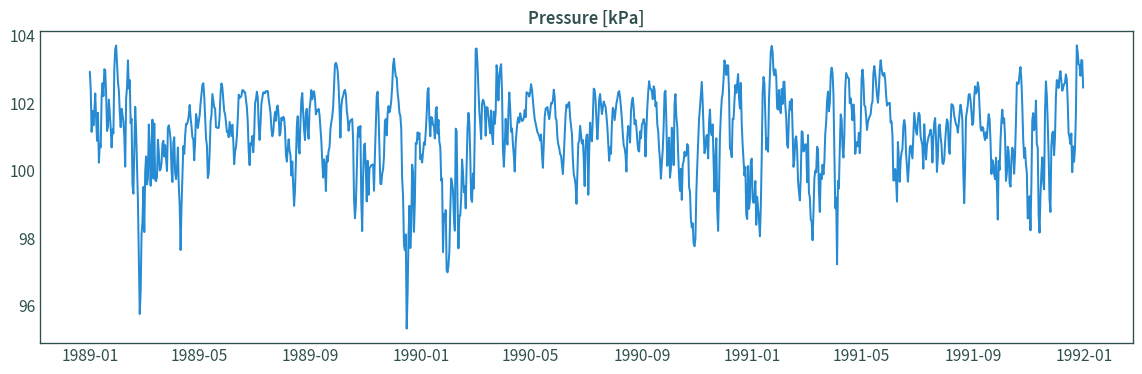

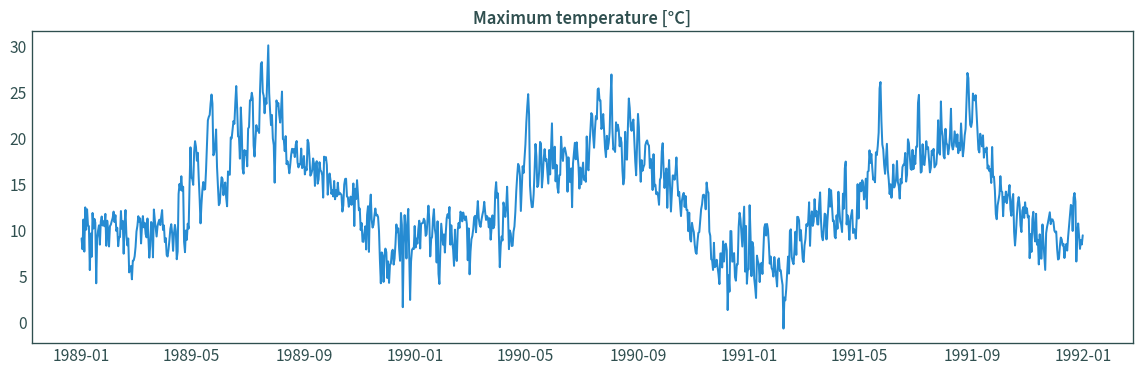

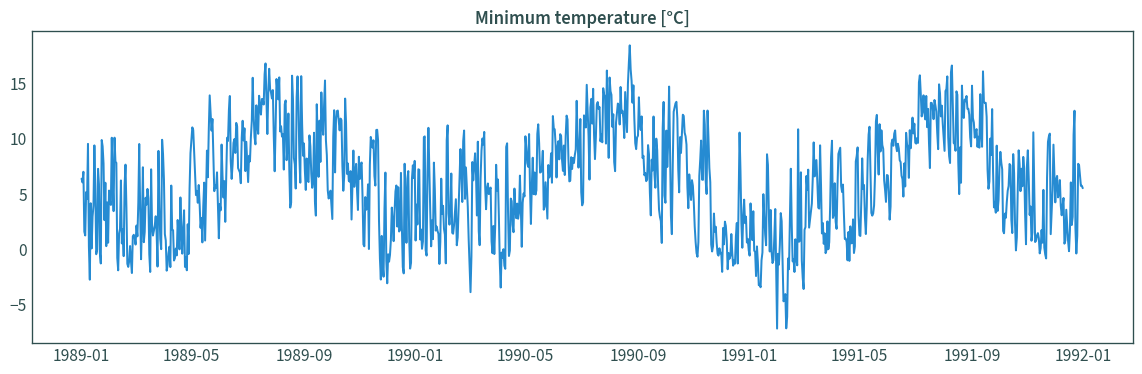

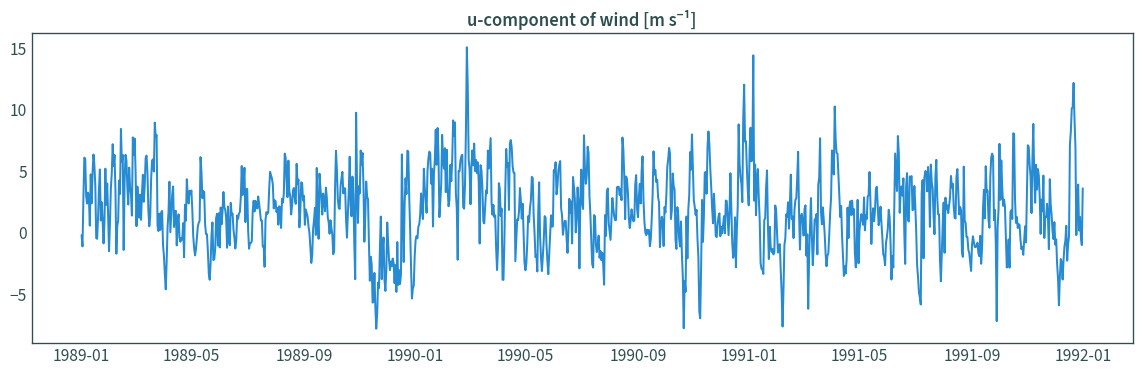

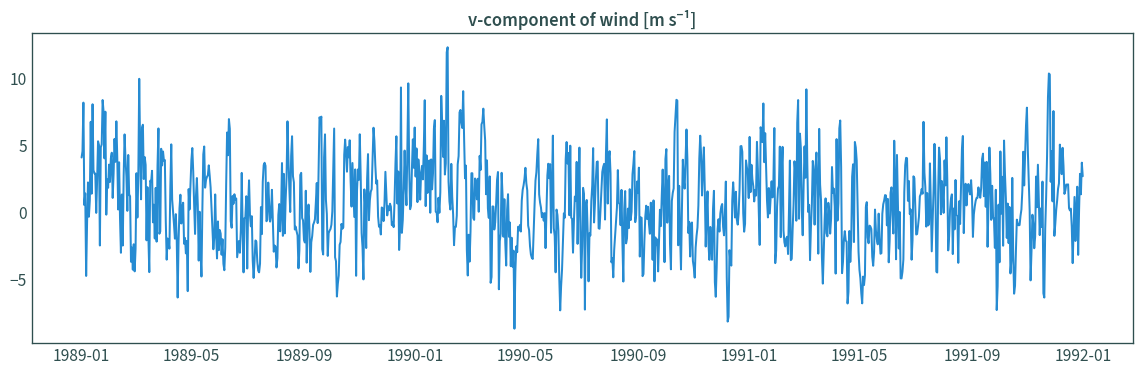

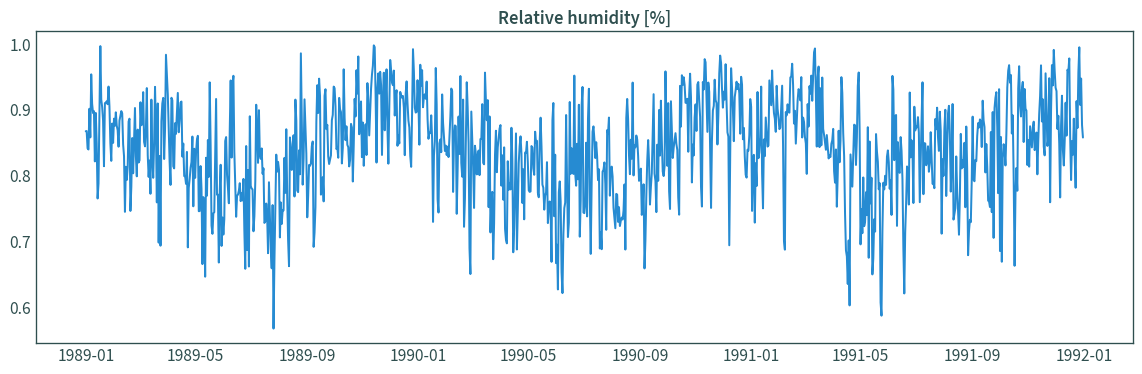

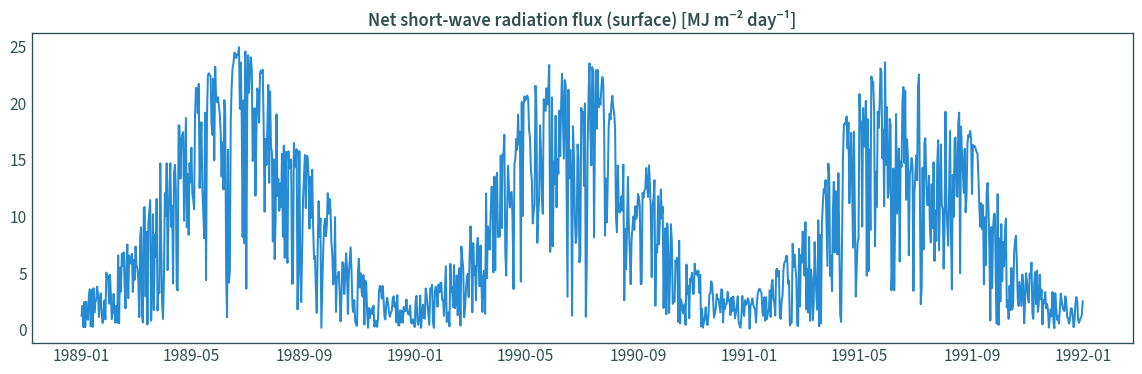

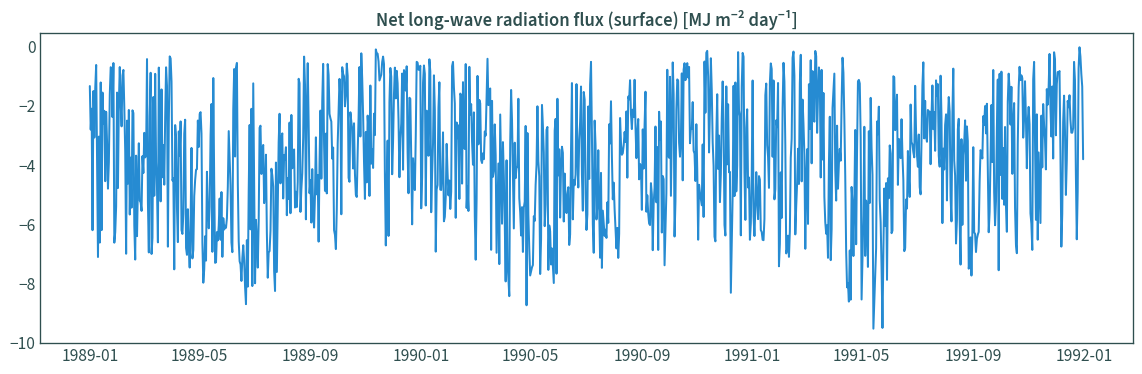

In [13]:
for v in var_dirs:
    var = list(ds[v].data_vars)[0]
    plot_ts(ds[v], var)

## Prepare variables to calculate ET

### Mean air temperature

Due to the non-linearity of humidity data required in the FAO
Penman-Monteith equation, the vapour pressure for a certain period should
be computed as the mean between the vapour pressure at the daily maximum
and minimum air temperatures of that period.

The daily maximum air temperature and daily minimum air temperature are,
respectively, the maximum and minimum air temperature observed during the
24-hour period, beginning at midnight.

The mean daily air temperature is only employed in the FAO Penman-Monteith
equation to calculate the slope of the saturation vapour pressure curves
and the impact of mean air density as the effect of temperature variations
on the value of the climatic parameter is small in these cases.

For standardisation, the mean temperature for 24-hour periods is defined
as the mean of the daily maximum and minimum temperatures rather than as
the average of hourly temperature measurements.

Equation (9) in Allen et al. (1998), p.33

$$T_{mean} = \frac{T_{max} + T_{min}}{2}$$

- $T_{mean}$: mean air temperature at 2 m height [°C]
- $T_{max}$: maximum air temperature at 2 m height [°C]
- $T_{min}$: minimum air temperature at 2 m height [°C]

In [14]:
t_mean = xr.combine_by_coords(
    [ds["15_105_2_2"], ds["16_105_2_2"]], combine_attrs="drop_conflicts"
)

In [15]:
t_mean = t_mean.assign(t_mean=(t_mean["tmax"] + t_mean["tmin"]) / 2)
t_mean["t_mean"].attrs["units"] = "°C"
t_mean["t_mean"].attrs["long_name"] = "Mean temperature"
t_mean = t_mean.drop_vars(["tmax", "tmin"])
t_mean.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    t_mean             (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

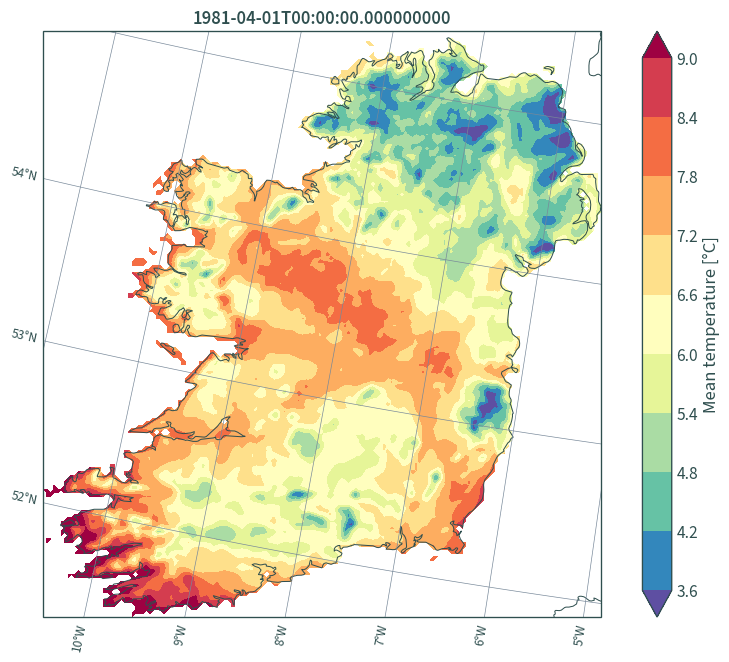

In [16]:
plot_map(t_mean, "t_mean")

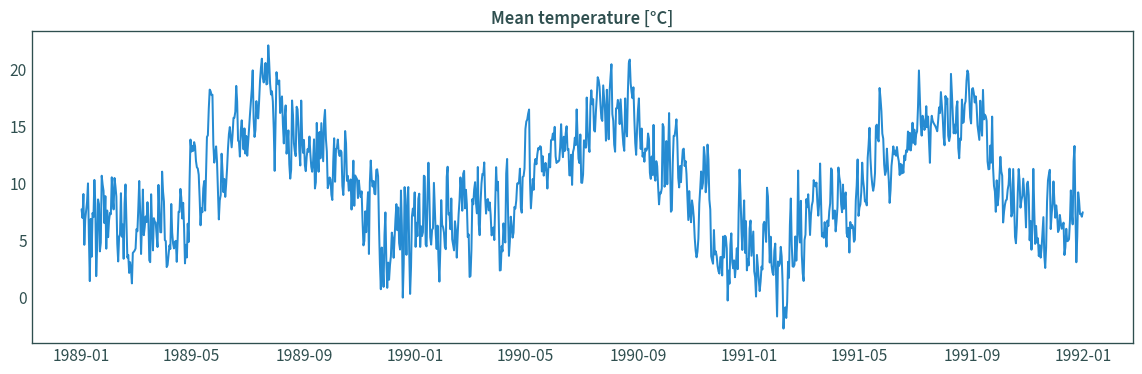

In [17]:
plot_ts(t_mean, "t_mean")

### Net radiation

The net radiation is the difference between the incoming net shortwave
radiation and the outgoing net longwave radiation.

Equation (40) in Allen et al. (1998), p. 53

$$R_n = R_{ns} - R_{nl}$$

- $R_n$: net radiation at the crop surface [MJ m⁻² day⁻¹]
- $R_{ns}$: incoming net shortwave radiation [MJ m⁻² day⁻¹]
- $R_{nl}$: outgoing net longwave radiation [MJ m⁻² day⁻¹]

In [18]:
r_n = xr.combine_by_coords(
    [ds["111_105_0_4"], ds["112_105_0_4"]], combine_attrs="drop_conflicts"
)

In [19]:
# since both are incoming, they must be added, not subtracted
r_n = r_n.assign(r_n=r_n["nswrs"] + r_n["nlwrs"])
r_n["r_n"].attrs["units"] = "MJ m⁻² day⁻¹"
r_n["r_n"].attrs["long_name"] = "Net radiation"
r_n = r_n.drop_vars(["nswrs", "nlwrs"])
r_n.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    r_n                (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

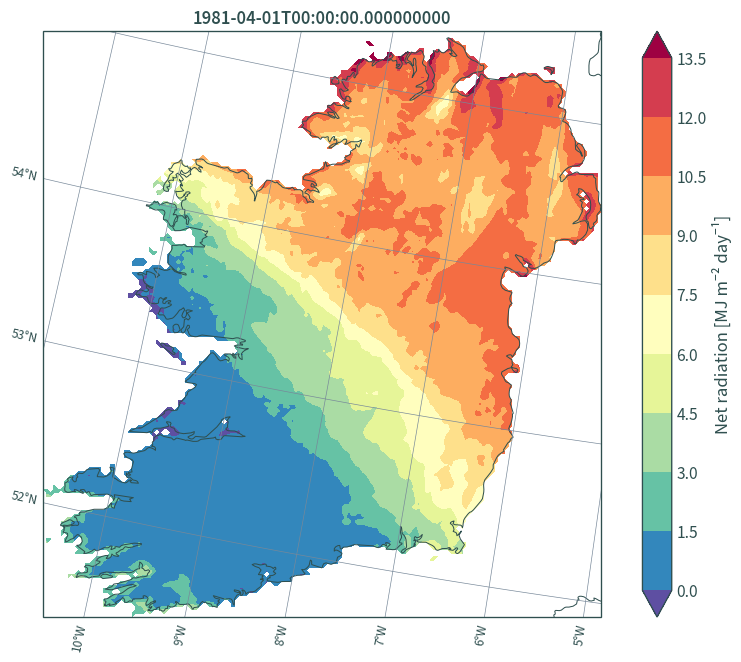

In [20]:
plot_map(r_n, "r_n")

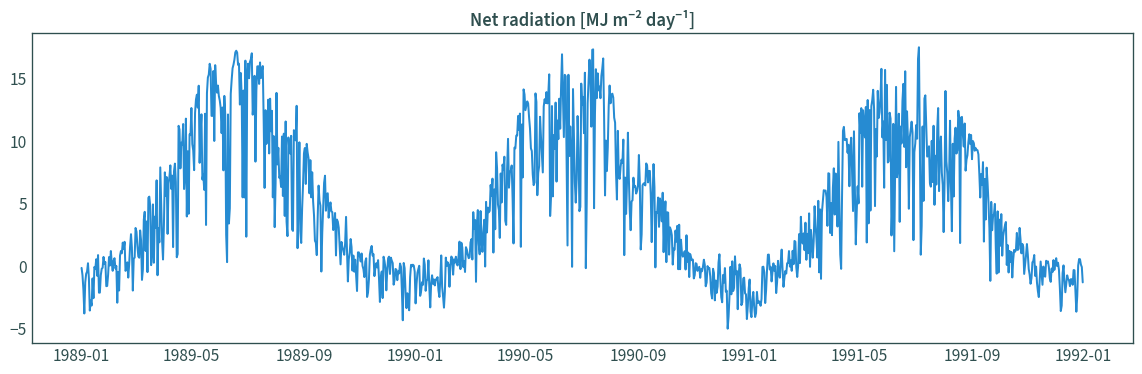

In [21]:
plot_ts(r_n, "r_n")

### Saturation vapour pressure

Equation (11) in Allen et al. (1998), p. 36

$$e^o(T) = 0.6108 \times \exp\left(\frac{17.27 T}{T + 237.3}\right)$$

- $e^o(T)$: saturation vapour pressure at the air temperature T [kPa]
- $T$: air temperature [°C]

Equation (12) in Allen et al. (1998), p. 36

$$e_s = \frac{e^o(T_{max}) + e^o(T_{min})}{2}$$

- $e_s$: mean saturation vapour pressure [kPa]
- $e^o(T_{max})$: saturation vapour pressure at the maximum air temperature
  [kPa]
- $e^o(T_{min})$: saturation vapour pressure at the minimum air temperature
  [kPa]

In [22]:
e_s = xr.combine_by_coords(
    [ds["15_105_2_2"], ds["16_105_2_2"]], combine_attrs="drop_conflicts"
)

In [23]:
e_s = e_s.assign(
    e_s_tmax=0.6108 * np.exp((17.27 * e_s["tmax"]) / (e_s["tmax"] + 237.3))
)
e_s = e_s.assign(
    e_s_tmin=0.6108 * np.exp((17.27 * e_s["tmin"]) / (e_s["tmin"] + 237.3))
)
e_s = e_s.assign(e_s=(e_s["e_s_tmax"] + e_s["e_s_tmin"]) / 2)
e_s["e_s"].attrs["units"] = "kPa"
e_s["e_s"].attrs["long_name"] = "Mean saturation vapour pressure"
e_s = e_s.drop_vars(["tmax", "tmin", "e_s_tmax", "e_s_tmin"])
e_s.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    e_s                (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

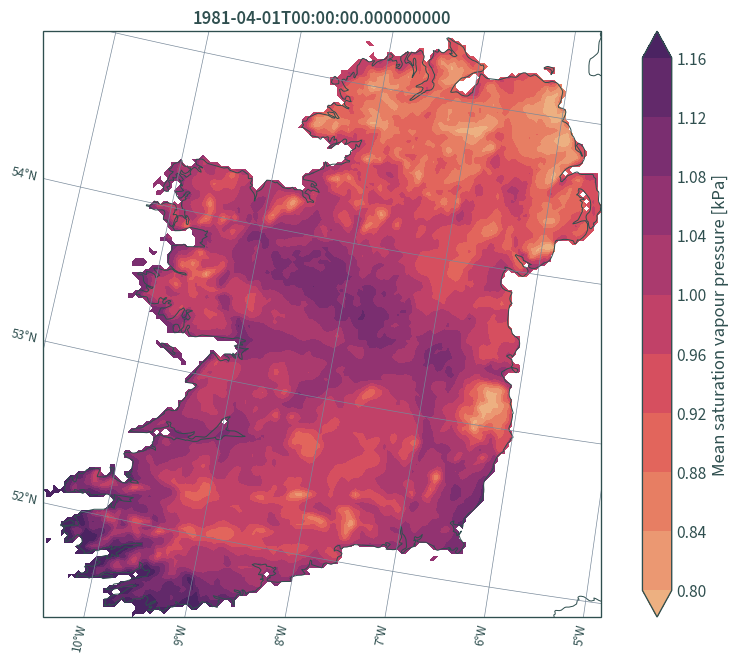

In [24]:
plot_map(e_s, "e_s", cplt.cmap_flare)

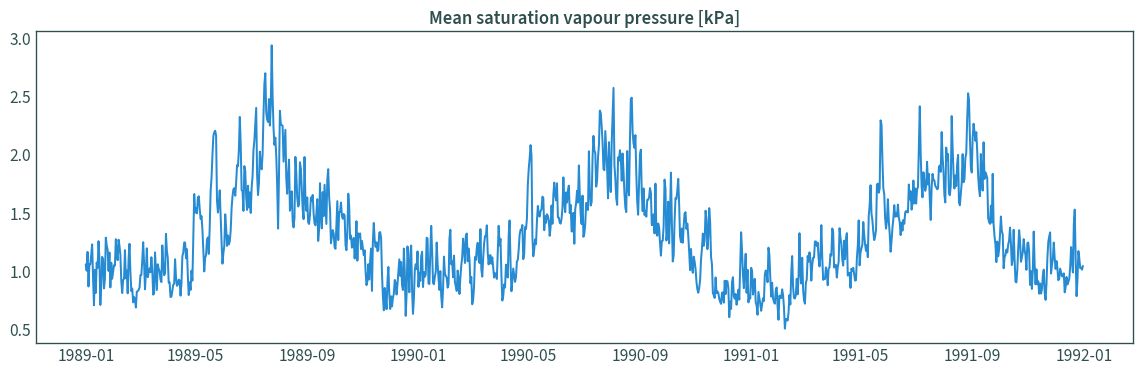

In [25]:
plot_ts(e_s, "e_s")

### Slope vapour pressure curve

The slope of the relationship between saturation vapour pressure and
temperature.

Equation (13) in Allen et al. (1998), p. 37

$$Δ = \frac{4098 \times (0.6108 \times \exp(\frac{17.27 T}{T + 237.3}))}
  {(T + 237.3)^2}$$

- $Δ$: slope vapour pressure curve [kPa °C⁻¹]
- $T$: mean air temperature at 2 m height [°C]

In the FAO Penman-Monteith equation, where $∆$ occurs in the numerator and
denominator, the slope of the vapour pressure curve is calculated using mean
air temperature.

In [26]:
delta = t_mean.copy()

In [27]:
delta = delta.assign(
    delta=(
        4098 *
        (
            0.6108 * np.exp((17.27 * delta["t_mean"]) /
            (delta["t_mean"] + 237.3))
        ) /
        np.power((delta["t_mean"] + 273.3), 2)
    )
)
delta["delta"].attrs["units"] = "kPa"
delta["delta"].attrs["long_name"] = "Slope vapour pressure curve"
delta = delta.drop_vars(["t_mean"])
delta.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    delta              (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

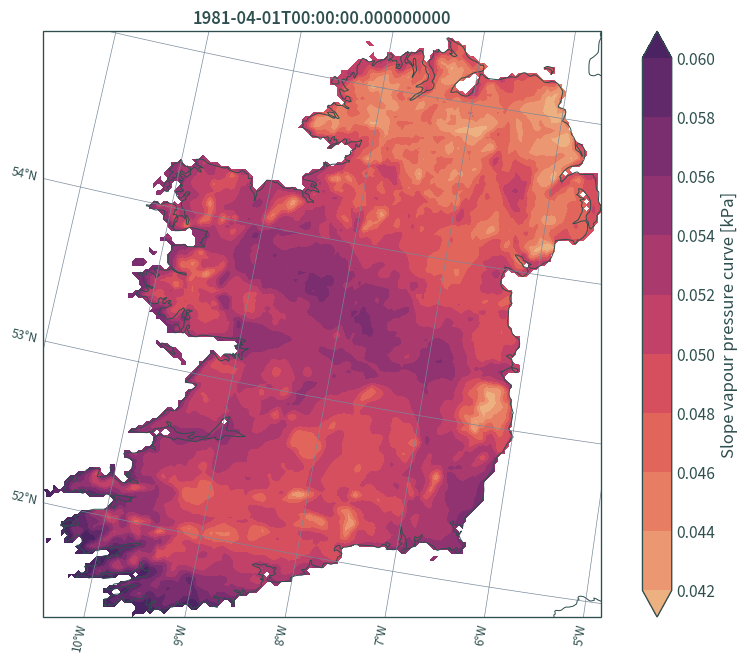

In [28]:
plot_map(delta, "delta", cplt.cmap_flare)

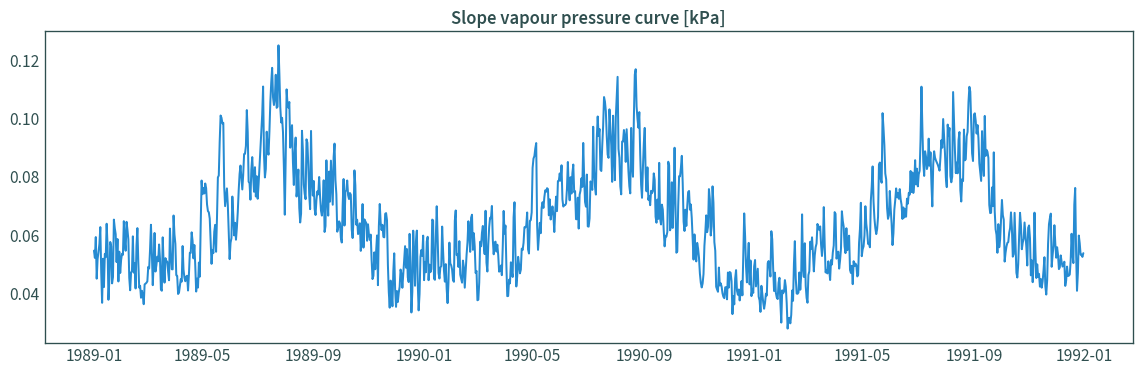

In [29]:
plot_ts(delta, "delta")

### Psychrometric constant

The psychrometric constant is the ratio of specific heat of moist air at
constant pressure to latent heat of vaporisation of water. It can be
estimated from atmospheric pressure.

This method assumes that the air is saturated with water vapour at the
minimum daily temperature.

Equation (8) in Allen et al (1998), p. 32

$γ = 0.665 \times 10^{-3} \times P$

- $γ$: psychrometric constant [kPa °C⁻¹]
- $P$: atmospheric pressure [kPa]

In [30]:
gamma = ds["1_105_0_0"].copy()

In [31]:
gamma = gamma.assign(gamma=0.665 / 1000 * gamma["pres"])
gamma["gamma"].attrs["units"] = "kPa °C⁻¹"
gamma["gamma"].attrs["long_name"] = "Psychrometric constant"
gamma = gamma.drop_vars(["pres"])
gamma.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    gamma              (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 15:36:57 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

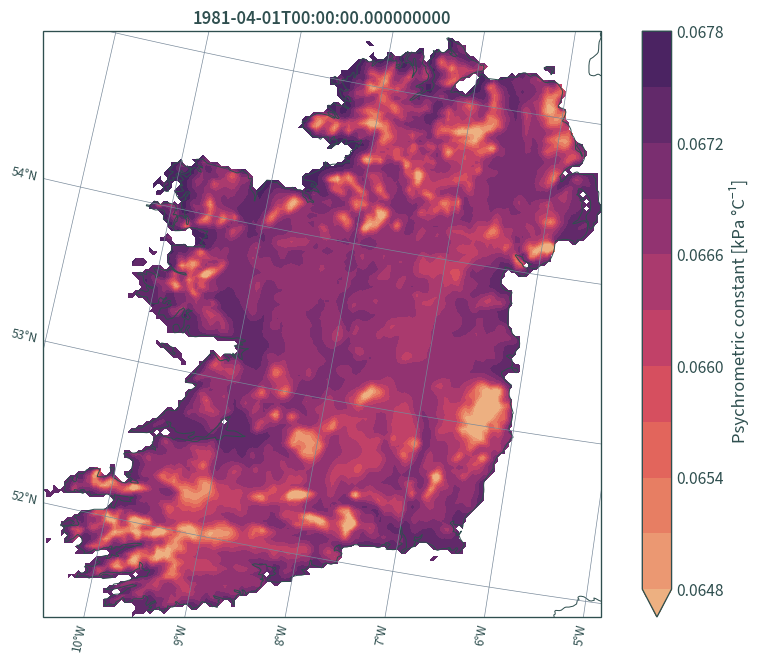

In [32]:
plot_map(gamma, "gamma", cplt.cmap_flare)

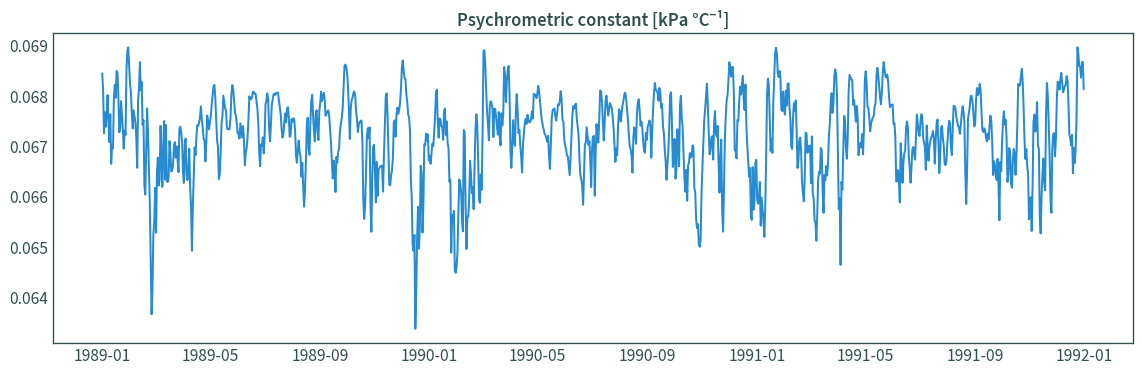

In [33]:
plot_ts(gamma, "gamma")

### Wind speed

Calculate the wind speed using u- and v-components.

http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv

$$w = \sqrt{u^2 + v^2}$$

- $w$: wind speed [m s⁻¹]
- $u$: u-component of wind speed [m s⁻¹]
- $v$: v-component of wind speed [m s⁻¹]

If not measured at 2 m height, convert wind speed measured at different
heights above the soil surface to wind speed at 2 m above the surface,
assuming a short grass surface.

Equation (47) in Allen et al (1998), p. 56

$$w_2 = w_z \times \frac{4.87}{\ln(67.8 z - 5.42)}$$

- $w_2$: wind speed at 2 m height [m s⁻¹]
- $w_z$: measured wind speed at z m above ground surface [m s⁻¹]
- $z$: height of measurement above ground surface [m]

In [34]:
w_2 = xr.combine_by_coords(
    [ds["33_105_10_0"], ds["34_105_10_0"]], combine_attrs="drop_conflicts"
)

In [35]:
w_2 = w_2.assign(w=np.hypot(w_2["u"], w_2["v"]))
w_2 = w_2.assign(w_2=w_2["w"] * (4.87 / np.log((67.8 * 10.0) - 5.42)))
w_2["w_2"].attrs["units"] = "m s⁻¹"
w_2["w_2"].attrs["long_name"] = "Wind speed at 2 m height"
w_2 = w_2.drop_vars(["u", "v", "w"])
w_2.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 10.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    w_2                (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

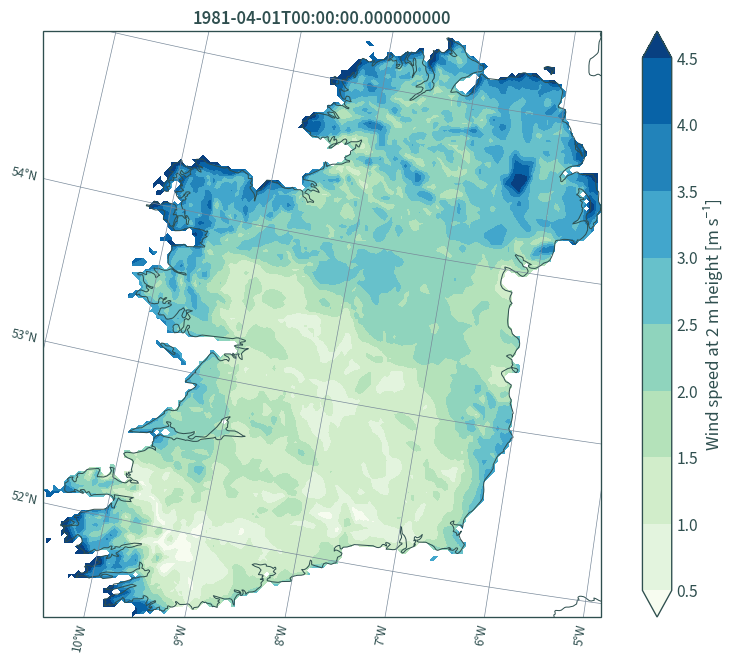

In [36]:
plot_map(w_2, "w_2", "GnBu")

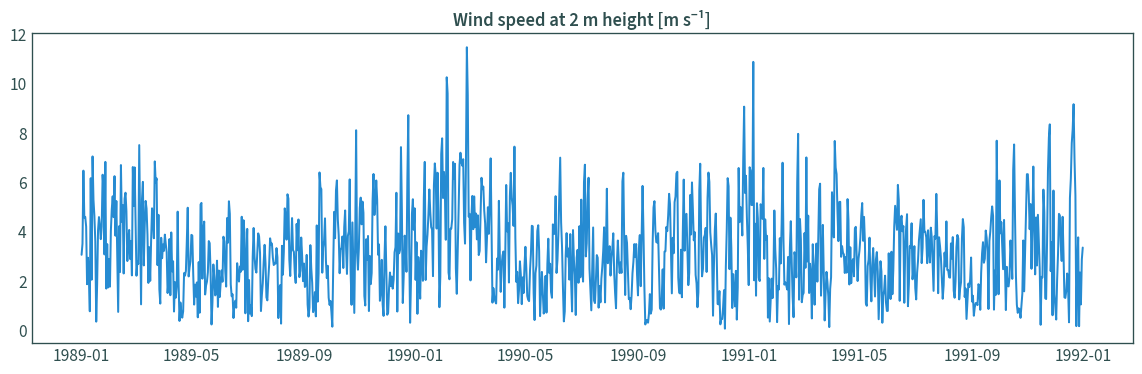

In [37]:
plot_ts(w_2, "w_2")

### Actual vapour pressure

In the absence of dewpoint temperature, or psychrometric data (i.e. wet
and dry bulb temperatures), or maximum (and minimum) relative humidity,
the mean relative humidity is used to calculate the actual vapour
pressure.

Equation (19) in Allen et al. (1998), p. 39

$$e_a = \frac{RH_{mean}}{100} \times \frac{e^o(T_{max}) + e^o(T_{min})}{2}
  = \frac{RH_{mean}}{100} \times e_s$$

- $e_a$: actual vapour pressure [kPa]
- $RH_{mean}$: mean relative humidity [%]
- $e_s$: saturation vapour pressure [kPa]

In [38]:
e_a = xr.combine_by_coords(
    [ds["52_105_2_0"], e_s], combine_attrs="drop_conflicts"
)

In [39]:
e_a = e_a.assign(e_a=e_a["r"] * e_a["e_s"])  # "r" ranges from 0.0 - 1.0
e_a["e_a"].attrs["units"] = "kPa"
e_a["e_a"].attrs["long_name"] = "Actual vapour pressure"
e_a = e_a.drop_vars(["r", "e_s"])
e_a.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    e_a                (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    history:      Wed Mar 22 15:37:24 2023: cdo -s -f nc4c -shifttime,-3hour ...

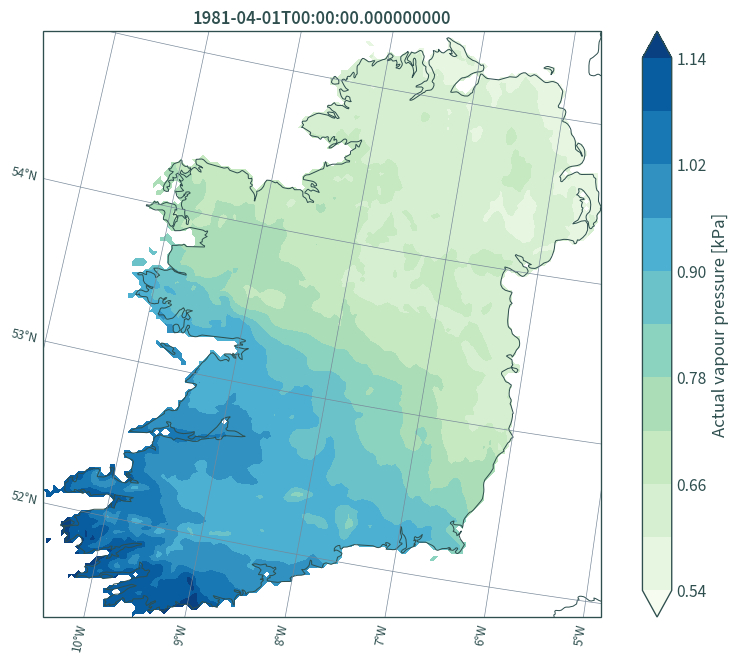

In [40]:
plot_map(e_a, "e_a", "GnBu")

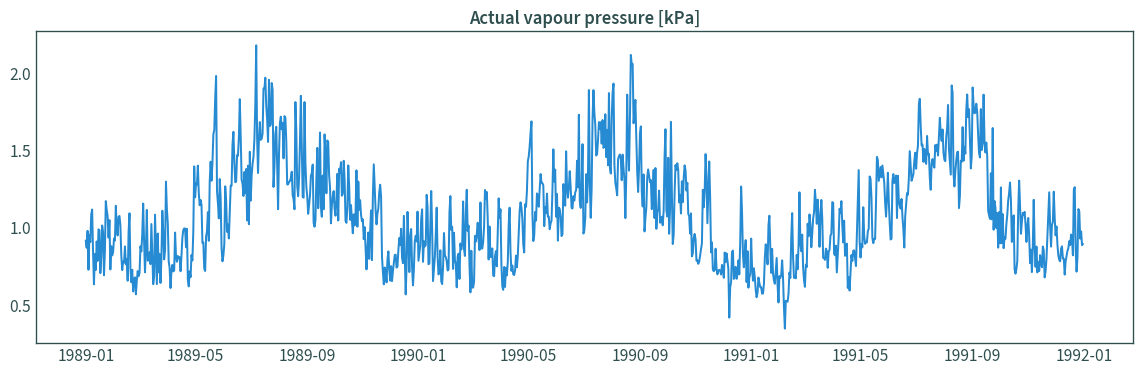

In [41]:
plot_ts(e_a, "e_a")

## Calculate evapotranspiration

The FAO Penman-Monteith equation.

Equation (6) in Allen et al. (1998), p. 24

$$ET_o = \frac{0.408 \times Δ \times (R_n - G) + γ \times \frac{900}{T + 273}
  \times w_2 \times (e_s - e_a)}{Δ + γ \times (1 + 0.34 \times w_2)}$$

- $ET_o$: reference evapotranspiration [mm day⁻¹]
- $Δ$: slope vapour pressure curve [kPa °C⁻¹]
- $R_n$: net radiation at the crop surface [MJ m⁻² day⁻¹]
- $G$: soil heat flux density [MJ m⁻² day⁻¹]
- $γ$: psychrometric constant [kPa °C⁻¹]
- $T$: mean daily air temperature at 2 m height [°C]
- $w_2$: wind speed at 2 m height [m s⁻¹]
- $e_s$: saturation vapour pressure [kPa]
- $e_a$: actual vapour pressure [kPa]

The soil heat flux is small compared to net radiation, particularly when
the surface is covered by vegetation. As the magnitude of the day heat
flux beneath the grass reference surface is relatively small, it may be
ignored.

Equation (42) in Allen et al. (1998), p. 54

In [42]:
eto = xr.combine_by_coords(
    [delta, gamma, r_n, t_mean, w_2, e_s, e_a],
    combine_attrs="drop_conflicts", compat="override"
)

In [43]:
eto = eto.assign(
    PET=(
            (
                (0.408 * eto["delta"] * eto["r_n"]) +
                eto["gamma"] * (900 / (eto["t_mean"] + 273)) *
                eto["w_2"] * (eto["e_s"] - eto["e_a"])
            ) /
            (eto["delta"] + eto["gamma"] * (1 + 0.34 * eto["w_2"]))
    )
)

In [44]:
eto["PET"].attrs["units"] = "mm day⁻¹"
eto["PET"].attrs["long_name"] = "Reference evapotranspiration"
eto = eto.drop_vars(["delta", "gamma", "e_a", "e_s", "r_n", "t_mean", "w_2"])
eto.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 2.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    PET                (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

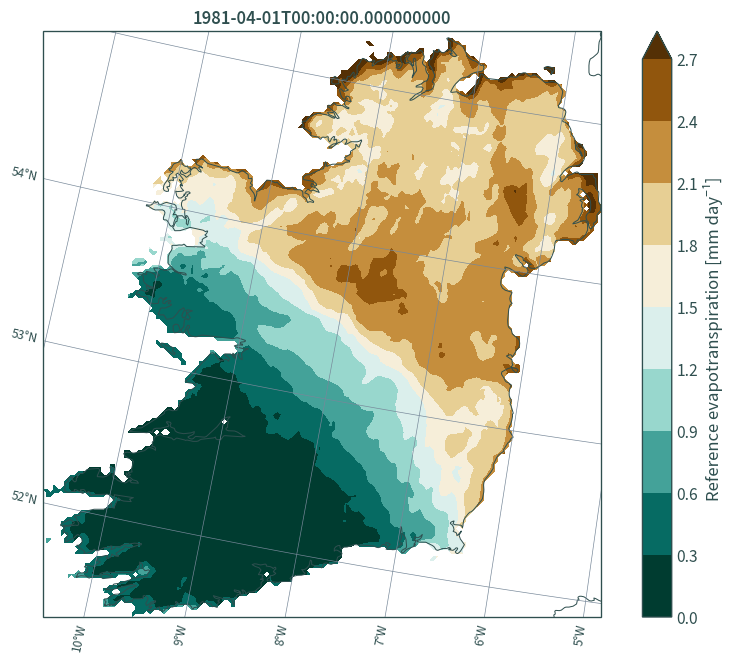

In [45]:
plot_map(eto, "PET", "BrBG_r")

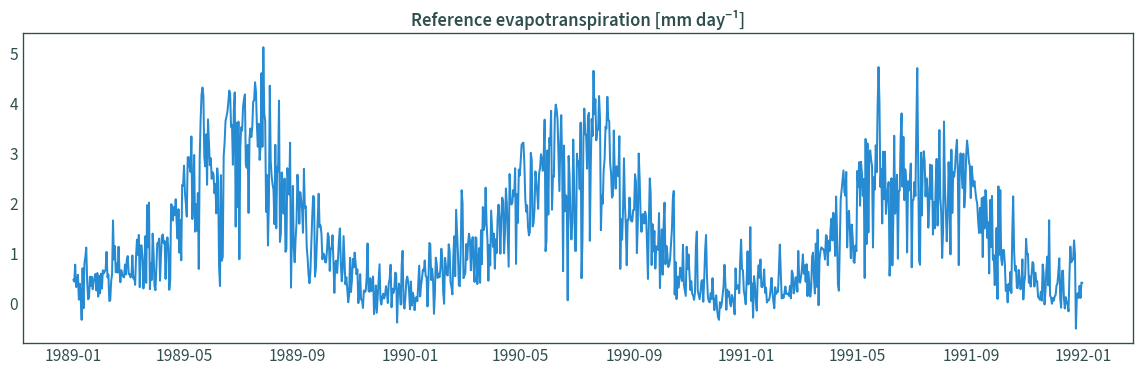

In [46]:
plot_ts(eto, "PET")

In [ ]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-03-24 14:00:01.960950+00:00
